@author: eveomett AI for Redistricting, USF All data retrieved 05/25/24:
https://redistrictingdatahub.org/dataset/south-carolina-block-pl-94171-2020-by-table/

https://redistrictingdatahub.org/dataset/2022-south-carolina-congressional-districts-approved-plan/

https://redistrictingdatahub.org/dataset/vest-2020-south-carolina-precinct-and-election-results/
https://redistrictingdatahub.org/dataset/vest-2018-south-carolina-precinct-and-election-results/
https://redistrictingdatahub.org/dataset/vest-2016-south-carolina-precinct-and-election-results/    

https://redistrictingdatahub.org/dataset/2021-south-carolina-state-senate-approved-plan/
https://redistrictingdatahub.org/dataset/2024-south-carolina-house-of-representatives-districts-approved-plan/

In [1]:
import pandas as pd
import geopandas as gpd
import maup
import time
from maup import smart_repair
from gerrychain import Graph

maup.progress.enabled = True

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# state = Tennessee
state_ab = "sc"

## Data
1. Download all the data in directory "tn_data"
2. Extract them all

In [4]:
data_folder = state_ab + "_data/"
population1_data = "./{}{}_pl2020_b/{}_pl2020_p1_b.shp".format(data_folder, state_ab, state_ab)
population2_data = "./{}{}_pl2020_b/{}_pl2020_p2_b.shp".format(data_folder, state_ab, state_ab)
vap_data =  "./{}{}_pl2020_b/{}_pl2020_p4_b.shp".format(data_folder, state_ab, state_ab)
vest20_data = "./{}{}_vest_20/{}_vest_20.shp".format(data_folder, state_ab, state_ab)
vest18_data = "./{}{}_vest_18/{}_vest_18.shp".format(data_folder, state_ab, state_ab)
vest16_data = "./{}{}_vest_16/{}_vest_16.shp".format(data_folder, state_ab, state_ab)
cd_data = "./{}{}_cong_adopted_2022/S865_Congress.shp".format(data_folder, state_ab)
send_data = "./{}{}_sldu_2021/sc_sldu_2021.shp".format(data_folder, state_ab)
hdist_data = "./{}{}_sldl_adopted_2024_shp/S1024.shp".format(data_folder, state_ab)

In [5]:
def do_smart_repair(df):
    # change it to the UTM it needs for smart_repair
    df = df.to_crs(df.estimate_utm_crs())
    df = smart_repair(df)
    if maup.doctor(df):
        print('smart_repair successful')
            
        # change it back to this UTM for this data
        df = df.to_crs('EPSG:4269')
    else:
        raise Exception('smart_repair failed')
    return df

In [6]:
def add_district(dist_df, dist_name, election_df, col_name):
    # check if it needs to be smart_repair
    if maup.doctor(dist_df) != True:
        dist_df = do_smart_repair(dist_df)
    
    election_df = gpd.GeoDataFrame(election_df, crs="EPSG:4269")
    
    # assign the pricincts
    precincts_to_district_assignment = maup.assign(election_df.geometry, dist_df.geometry)
    election_df[dist_name] = precincts_to_district_assignment
    for precinct_index in range(len(election_df)):
        election_df.at[precinct_index, dist_name] = dist_df.at[election_df.at[precinct_index, dist_name], col_name]
    
    return election_df

In [7]:
def rename(original, year):
    party = original[6]
    if party == 'R' or party == 'D':
        return original[3:6] + year + original[6]
    else:
        return original[3:6] + year + 'O'

In [8]:
pop_col = ['TOTPOP', 'HISP', 'NH_WHITE', 'NH_BLACK', 'NH_AMIN', 'NH_ASIAN', 'NH_NHPI', 'NH_OTHER', 'NH_2MORE', 'H_WHITE', 'H_BLACK', 'H_AMIN', 'H_ASIAN', 'H_NHPI', 'H_OTHER', 'H_2MORE', 'VAP', 'HVAP', 'WVAP', 'BVAP', 'AMINVAP', 'ASIANVAP', 'NHPIVAP', 'OTHERVAP', '2MOREVAP']

In [9]:
def check_population(population, df):
    pop_check = pd.DataFrame({
        'pop_col': pop_col,
        'population_df': population[pop_col].sum(), 
        'vest_base': df[pop_col].sum(),
        'equal': [x == y for x, y in zip(population[pop_col].sum(), df[pop_col].sum())]
    })
    if pop_check['equal'].mean() < 1:
        print(pop_check)
        raise Exception("population doesn't agree")

    else:
        print("population agrees")

In [10]:
def add_vest(vest, df, year, population, start_col):    
     # check if it needs to be smart_repair
    if maup.doctor(vest) != True:
        vest = do_smart_repair(vest)
    
    # rename the columns
    original_col = vest.columns[start_col:-1]
    new_col = [rename(i, year) for i in original_col]
    rename_dict = dict(zip(original_col, new_col))
    vest = vest.rename(columns=rename_dict)
    vest = vest.groupby(level=0, axis=1).sum() # combine all the other party's vote into columns with sufix "O"
    col_name = list(set(new_col))
    col_name.sort()
    
    # make the blocks from precincts by weight
    vest = gpd.GeoDataFrame(vest, crs="EPSG:4269")
    election_in_block = population[["VAP", 'geometry']] # population_df is in block scale
    blocks_to_precincts_assignment = maup.assign(election_in_block.geometry, vest.geometry)

    weights = election_in_block["VAP"] / blocks_to_precincts_assignment.map(election_in_block["VAP"].groupby(blocks_to_precincts_assignment).sum())
    weights = weights.fillna(0)
    prorated = maup.prorate(blocks_to_precincts_assignment, vest[col_name], weights)
    election_in_block[col_name] = prorated

    # assign blocks to precincts
    election_in_block = gpd.GeoDataFrame(election_in_block, crs="EPSG:4269")
    df = gpd.GeoDataFrame(df, crs="EPSG:4269")
    block_to_pricinct_assginment = maup.assign(election_in_block.geometry, df.geometry)
    df[col_name] = election_in_block[col_name].groupby(block_to_pricinct_assginment).sum()
    df = df.groupby(level=0, axis=1).sum()
    
    # check if population agrees
    check_population(population, df)
        
    return df

### Read the census data

In [11]:
population1_df = gpd.read_file(population1_data)
population2_df = gpd.read_file(population2_data)
vap_df = gpd.read_file(vap_data)

In [12]:
population2_df = population2_df.drop(columns=['SUMLEV', 'LOGRECNO', 'GEOID', 'COUNTY', 'geometry'])
vap_df = vap_df.drop(columns=['SUMLEV', 'LOGRECNO', 'GEOID', 'COUNTY', 'geometry'])

In [13]:
population_df = pd.merge(population1_df, population2_df, on='GEOID20')
population_df = pd.merge(population_df, vap_df, on='GEOID20')

In [14]:
maup.doctor(population_df)

100%|██████████| 146844/146844 [02:32<00:00, 961.62it/s] 


True

In [15]:
population_df['H_WHITE'] = population_df.apply(lambda t: t['P0010003'] - t['P0020005'], 1)
population_df['H_BLACK'] = population_df.apply(lambda t: t['P0010004'] - t['P0020006'], 1)
population_df['H_AMIN'] = population_df.apply(lambda t: t['P0010005'] - t['P0020007'], 1)
population_df['H_ASIAN'] = population_df.apply(lambda t: t['P0010006'] - t['P0020008'], 1)
population_df['H_NHPI'] = population_df.apply(lambda t: t['P0010007'] - t['P0020009'], 1)
population_df['H_OTHER'] = population_df.apply(lambda t: t['P0010008'] - t['P0020010'], 1)
population_df['H_2MORE'] = population_df.apply(lambda t: t['P0010009'] - t['P0020011'], 1)

In [16]:
rename_dict = {'P0020001': 'TOTPOP', 'P0020002': 'HISP', 'P0020005': 'NH_WHITE', 'P0020006': 'NH_BLACK', 'P0020007': 'NH_AMIN',
                    'P0020008': 'NH_ASIAN', 'P0020009': 'NH_NHPI', 'P0020010': 'NH_OTHER', 'P0020011': 'NH_2MORE',
                    'P0040001': 'VAP', 'P0040002': 'HVAP', 'P0040005': 'WVAP', 'P0040006': 'BVAP', 'P0040007': 'AMINVAP',
                                        'P0040008': 'ASIANVAP', 'P0040009': 'NHPIVAP', 'P0040010': 'OTHERVAP', 'P0040011': '2MOREVAP'}

In [17]:
population_df.rename(columns=rename_dict, inplace = True)

In [18]:
cong_df = gpd.read_file(cd_data)
if maup.doctor(cong_df) != True:
    cong_df = do_smart_repair(cong_df)

100%|██████████| 7/7 [00:00<00:00, 20.84it/s]


## Read the vest 20 data

Now using it as a "base pricinct"

In [19]:
def add_vest_base(vest, start_col, year):
    original_col = vest.columns[start_col:-1]
    new_col = [rename(i, year) for i in original_col]
    rename_dict = dict(zip(original_col, new_col))
    vest = vest.rename(columns=rename_dict)
    vest = vest.groupby(level=0, axis=1).sum()
    vest = gpd.GeoDataFrame(vest, crs="EPSG:4269")
    
    return vest

## Check if vest20 can be used as base

In [20]:
vest20 = gpd.read_file(vest20_data)
if maup.doctor(vest20) != True:
    vest20 = do_smart_repair(vest20)

100%|██████████| 2263/2263 [00:05<00:00, 422.29it/s]


There are 806 overlaps.
There are 2872 holes.
There are some invalid geometries.
Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.
Identifying overlaps...


100%|██████████| 11494/11494 [00:06<00:00, 1644.06it/s]


Resolving overlaps...
Assigning order 2 pieces...
Assigning order 3 pieces...
Filling gaps...


100%|██████████| 2263/2263 [00:04<00:00, 452.92it/s]


smart_repair successful


In [21]:
vest20.columns

Index(['COUNTY', 'PCODE', 'CODE_NAME', 'G20PRERTRU', 'G20PREDBID',
       'G20PRELJOR', 'G20PREGHAW', 'G20PREAFUE', 'G20USSRGRA', 'G20USSDHAR',
       'G20USSCBLE', 'G20USSOWRI', 'geometry'],
      dtype='object')

In [22]:
start_col = 3
vest_base_data = vest20
year = '20'

In [23]:
vest_base = add_vest_base(vest_base_data, start_col, year)

In [24]:
# vap and population have the same GEOID20
blocks_to_precincts_assignment = maup.assign(population_df.geometry, vest_base.geometry)

100%|██████████| 2263/2263 [00:22<00:00, 100.23it/s]


In [25]:
vest_base[pop_col] = population_df[pop_col].groupby(blocks_to_precincts_assignment).sum()

In [26]:
election_df = gpd.GeoDataFrame(vest_base, crs="EPSG:4269")

In [27]:
election_df.columns

Index(['CODE_NAME', 'COUNTY', 'PCODE', 'PRE20D', 'PRE20O', 'PRE20R', 'USS20D',
       'USS20O', 'USS20R', 'geometry', 'TOTPOP', 'HISP', 'NH_WHITE',
       'NH_BLACK', 'NH_AMIN', 'NH_ASIAN', 'NH_NHPI', 'NH_OTHER', 'NH_2MORE',
       'H_WHITE', 'H_BLACK', 'H_AMIN', 'H_ASIAN', 'H_NHPI', 'H_OTHER',
       'H_2MORE', 'VAP', 'HVAP', 'WVAP', 'BVAP', 'AMINVAP', 'ASIANVAP',
       'NHPIVAP', 'OTHERVAP', '2MOREVAP'],
      dtype='object')

## Check if population agrees

In [28]:
pd.DataFrame({
    'pop_col': pop_col,
    'population_df': population_df[pop_col].sum(), 
    'vest_base': vest_base[pop_col].sum(),
    'equal': [x == y for x, y in zip(population_df[pop_col].sum(), vest_base[pop_col].sum())]
})

,pop_col,population_df,vest_base,equal
TOTPOP,TOTPOP,5118425,5118425,True
HISP,HISP,352838,352838,True
NH_WHITE,NH_WHITE,3178552,3178552,True
NH_BLACK,NH_BLACK,1269031,1269031,True
NH_AMIN,NH_AMIN,16591,16591,True
NH_ASIAN,NH_ASIAN,89394,89394,True
NH_NHPI,NH_NHPI,3085,3085,True
NH_OTHER,NH_OTHER,19354,19354,True
NH_2MORE,NH_2MORE,189580,189580,True
H_WHITE,H_WHITE,64890,64890,True


## Add more vest data

In [29]:
vest18 = gpd.read_file(vest18_data)
vest16 = gpd.read_file(vest16_data)

In [30]:
vest18.columns

Index(['STATEFP', 'COUNTYFP', 'VTDST', 'NAME', 'G18GOVDSMI', 'G18GOVRMCM',
       'G18GOVOWRI', 'G18SOSDWHI', 'G18SOSRHAM', 'G18SOSOWRI', 'G18TREDGLE',
       'G18TREWGLE', 'G18TRERLOF', 'G18TREAWOR', 'G18TREOWRI', 'G18ATGDANA',
       'G18ATGWANA', 'G18ATGRWIL', 'G18ATGOWRI', 'G18COMRECK', 'G18COMOWRI',
       'G18SPIRMIT', 'G18SPIOWRI', 'G18AGRUNEL', 'G18AGRGEDM', 'G18AGRRWEA',
       'G18AGROWRI', 'geometry'],
      dtype='object')

In [31]:
vest16.columns

Index(['STATEFP', 'COUNTYFP', 'PCODE', 'NAME', 'G16PRERTRU', 'G16PREDCLI',
       'G16PRELJOH', 'G16PREGSTE', 'G16PREIMCM', 'G16PRECCAS', 'G16PREASKE',
       'G16USSRSCO', 'G16USSDDIX', 'G16USSLBLE', 'G16USSASCA', 'G16USSOWRI',
       'geometry'],
      dtype='object')

In [32]:
# check the result here
election_df = add_vest(vest18, election_df, '18', population_df, 4)

100%|██████████| 2247/2247 [00:05<00:00, 393.44it/s]


There are 5 overlaps.
There are 21 holes.
Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.
Identifying overlaps...


100%|██████████| 2333/2333 [00:01<00:00, 1617.99it/s]


Resolving overlaps...
Assigning order 2 pieces...
Filling gaps...


Gaps to simplify: 100%|██████████| 19/19 [00:03<00:00,  4.86it/s]
Gaps to fill: 0it [00:00, ?it/s]
100%|██████████| 2247/2247 [00:05<00:00, 415.21it/s]


smart_repair successful


100%|██████████| 2263/2263 [00:23<00:00, 95.77it/s] 


population agrees


In [33]:
election_df.columns

Index(['2MOREVAP', 'AGR18O', 'AGR18R', 'AMINVAP', 'ASIANVAP', 'ATG18D',
       'ATG18O', 'ATG18R', 'BVAP', 'CODE_NAME', 'COM18O', 'COM18R', 'COUNTY',
       'GOV18D', 'GOV18O', 'GOV18R', 'HISP', 'HVAP', 'H_2MORE', 'H_AMIN',
       'H_ASIAN', 'H_BLACK', 'H_NHPI', 'H_OTHER', 'H_WHITE', 'NHPIVAP',
       'NH_2MORE', 'NH_AMIN', 'NH_ASIAN', 'NH_BLACK', 'NH_NHPI', 'NH_OTHER',
       'NH_WHITE', 'OTHERVAP', 'PCODE', 'PRE20D', 'PRE20O', 'PRE20R', 'SOS18D',
       'SOS18O', 'SOS18R', 'SPI18O', 'SPI18R', 'TOTPOP', 'TRE18D', 'TRE18O',
       'TRE18R', 'USS20D', 'USS20O', 'USS20R', 'VAP', 'WVAP', 'geometry'],
      dtype='object')

In [34]:
election_df = add_vest(vest16, election_df, '16', population_df, 4)

100%|██████████| 2234/2234 [00:05<00:00, 417.77it/s]


There are 942 overlaps.
There are 7012 holes.
There are some invalid geometries.
Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.
Identifying overlaps...


100%|██████████| 12900/12900 [00:07<00:00, 1842.00it/s]


Resolving overlaps...
Assigning order 2 pieces...
Assigning order 3 pieces...
Filling gaps...


100%|██████████| 2234/2234 [00:03<00:00, 564.90it/s]


smart_repair successful


100%|██████████| 2263/2263 [00:20<00:00, 112.07it/s]


population agrees


##  Add the district data

In [35]:
send = gpd.read_file(send_data)
hdist = gpd.read_file(hdist_data)

In [36]:
cong_df.head()

,DISTRICT,POPULATION,DEVIATION,F_DEVIATIO,HISPANIC_O,F_HISPANIC,NH_WHT,F_NH_WHT,NH_DOJ_BLK,F_NH_DOJ_B,F18_POP,F_18_POP,H18_POP,F_H18_POP,NH18_WHT,F_NH18_WHT,NH18_DOJ_B,F_NH18_DOJ,geometry
0,1,731203,-1.0,-0.000001,59591,0.081497,498807,0.682173,130245,0.178124,570538,0.780273,38918,0.068213,405889,0.711414,95400,0.167211,"POLYGON ((-79.44670 33.21346, -79.44621 33.213..."
1,2,731203,-1.0,-0.000001,51434,0.070342,446768,0.611004,190488,0.260513,563028,0.770002,33556,0.059599,360714,0.640668,137891,0.244910,"POLYGON ((-81.13928 34.06834, -81.13902 34.068..."
2,3,731204,0.0,0.000000,42512,0.058140,524457,0.717251,132875,0.181721,577297,0.789516,27422,0.047501,427484,0.740492,98848,0.171226,"POLYGON ((-81.33896 34.19759, -81.33898 34.197..."
3,4,731204,0.0,0.000000,77653,0.106199,468620,0.640888,142090,0.194323,565412,0.773262,50888,0.090002,379099,0.670483,104145,0.184193,"POLYGON ((-82.45514 34.75068, -82.45528 34.750..."
4,5,731204,0.0,0.000000,39825,0.054465,468920,0.641298,182332,0.249359,562685,0.769532,25482,0.045286,374151,0.664939,135206,0.240287,"POLYGON ((-80.35231 33.87588, -80.35207 33.875..."


In [37]:
election_df = add_district(cong_df, "CD", election_df, "DISTRICT")

100%|██████████| 7/7 [00:01<00:00,  3.92it/s]


In [38]:
send.head()

,ID,AREA,DISTRICT,MEMBERS,LOCKED,NAME,POPULATION,HISPANIC_O,NH_WHT,NH_DOJ_BLK,...,F_G20P_DV,F_G20P_RV,F_G20S_DV,F_G20S_RV,MULTIPLE_F,F_INGRP_CO,F_INGRP_IN,F_PEOPLE_I,DISTRICT_L,geometry
0,1,718.418213,1,1.0,None,None,110467,5876,88773,9028,...,0.298565,0.701435,0.300292,0.699708,1|-0.72%|29.86%|70.14%|30.03%|69.97%,0.001258,0.005404,0.074873,1|-0.72%,"POLYGON ((-82.89750 35.05618, -82.89754 35.056..."
1,2,707.279419,10,1.0,None,None,113230,7121,76903,24077,...,0.328773,0.671227,0.334614,0.665386,10|1.76%|32.88%|67.12%|33.46%|66.54%,0.004875,0.015738,0.031255,10|1.76%,"POLYGON ((-81.47197 34.07655, -81.47190 34.076..."
2,3,179.357925,11,1.0,None,None,114799,10962,68175,29085,...,0.397482,0.602518,0.413144,0.586856,11|3.17%|39.75%|60.25%|41.31%|58.69%,0.008807,0.016254,0.044173,11|3.17%,"POLYGON ((-81.92258 34.95728, -81.92207 34.956..."
3,4,148.798386,12,1.0,None,None,116372,11610,72615,23341,...,0.402806,0.597194,0.409886,0.590114,12|4.59%|40.28%|59.72%|40.99%|59.01%,0.000077,0.003343,0.006393,12|4.59%,"POLYGON ((-82.20178 34.94807, -82.19981 34.948..."
4,5,592.801880,13,1.0,None,None,113911,6225,81672,20052,...,0.343869,0.656131,0.350526,0.649474,13|2.37%|34.39%|65.61%|35.05%|64.95%,0.009288,0.018269,0.026565,13|2.37%,"POLYGON ((-81.85030 35.03285, -81.85030 35.032..."


In [39]:
election_df = add_district(send, "SEND", election_df, "DISTRICT")

100%|██████████| 46/46 [00:03<00:00, 12.16it/s]


In [40]:
hdist.head()

,Name,descriptio,timestamp,begin,end,altitudeMo,tessellate,extrude,visibility,drawOrder,icon,ID,geometry
0,1,None,None,None,None,None,-1,0,-1,None,None,1,"POLYGON Z ((-82.89807 35.05603 0.00000, -82.89..."
1,2,None,None,None,None,None,-1,0,-1,None,None,2,"POLYGON Z ((-82.85442 34.60972 0.00000, -82.85..."
2,3,None,None,None,None,None,-1,0,-1,None,None,3,"POLYGON Z ((-82.83741 34.65527 0.00000, -82.83..."
3,4,None,None,None,None,None,-1,0,-1,None,None,4,"POLYGON Z ((-82.83280 34.94897 0.00000, -82.83..."
4,5,None,None,None,None,None,-1,0,-1,None,None,5,"POLYGON Z ((-82.67378 34.72822 0.00000, -82.67..."


In [41]:
hdist = hdist.to_crs("EPSG:4269")
election_df = add_district(hdist, "HDIST", election_df, "Name")

100%|██████████| 124/124 [00:04<00:00, 28.25it/s]


In [42]:
election_df.columns

Index(['2MOREVAP', 'AGR18O', 'AGR18R', 'AMINVAP', 'ASIANVAP', 'ATG18D',
       'ATG18O', 'ATG18R', 'BVAP', 'CODE_NAME', 'COM18O', 'COM18R', 'COUNTY',
       'GOV18D', 'GOV18O', 'GOV18R', 'HISP', 'HVAP', 'H_2MORE', 'H_AMIN',
       'H_ASIAN', 'H_BLACK', 'H_NHPI', 'H_OTHER', 'H_WHITE', 'NHPIVAP',
       'NH_2MORE', 'NH_AMIN', 'NH_ASIAN', 'NH_BLACK', 'NH_NHPI', 'NH_OTHER',
       'NH_WHITE', 'OTHERVAP', 'PCODE', 'PRE16D', 'PRE16O', 'PRE16R', 'PRE20D',
       'PRE20O', 'PRE20R', 'SOS18D', 'SOS18O', 'SOS18R', 'SPI18O', 'SPI18R',
       'TOTPOP', 'TRE18D', 'TRE18O', 'TRE18R', 'USS16D', 'USS16O', 'USS16R',
       'USS20D', 'USS20O', 'USS20R', 'VAP', 'WVAP', 'geometry', 'CD', 'SEND',
       'HDIST'],
      dtype='object')

### Put the base precinct year after the precinct information column

In [43]:
base_columns = {}
if 'COUNTYFP' + year not in election_df.columns:
    base_columns = {
        'COUNTY':'COUNTY'+year,
        'PCODE':'PCODE'+year,
        'CODE_NAME':'CODE_NAME'+year}
election_df.rename(columns=base_columns, inplace = True)

In [44]:
election_df.columns

Index(['2MOREVAP', 'AGR18O', 'AGR18R', 'AMINVAP', 'ASIANVAP', 'ATG18D',
       'ATG18O', 'ATG18R', 'BVAP', 'CODE_NAME20', 'COM18O', 'COM18R',
       'COUNTY20', 'GOV18D', 'GOV18O', 'GOV18R', 'HISP', 'HVAP', 'H_2MORE',
       'H_AMIN', 'H_ASIAN', 'H_BLACK', 'H_NHPI', 'H_OTHER', 'H_WHITE',
       'NHPIVAP', 'NH_2MORE', 'NH_AMIN', 'NH_ASIAN', 'NH_BLACK', 'NH_NHPI',
       'NH_OTHER', 'NH_WHITE', 'OTHERVAP', 'PCODE20', 'PRE16D', 'PRE16O',
       'PRE16R', 'PRE20D', 'PRE20O', 'PRE20R', 'SOS18D', 'SOS18O', 'SOS18R',
       'SPI18O', 'SPI18R', 'TOTPOP', 'TRE18D', 'TRE18O', 'TRE18R', 'USS16D',
       'USS16O', 'USS16R', 'USS20D', 'USS20O', 'USS20R', 'VAP', 'WVAP',
       'geometry', 'CD', 'SEND', 'HDIST'],
      dtype='object')

In [45]:
# reorder the columns
fixed_columns = [
    'COUNTY'+year,
    'PCODE'+year,
    'CODE_NAME'+year,
    'CD',
    'SEND',
    'HDIST',
    'TOTPOP',
    'NH_2MORE',
    'NH_AMIN',
    'NH_ASIAN',
    'NH_BLACK',
    'NH_NHPI',
    'NH_OTHER',
    'NH_WHITE',
    'HISP',
    'H_AMIN',
    'H_ASIAN',
    'H_BLACK',
    'H_NHPI',
    'H_OTHER',
    'H_WHITE',
    'H_2MORE',
    'VAP',
    'HVAP',
    'WVAP',
    'BVAP',
    'AMINVAP',
    'ASIANVAP',
    'NHPIVAP',
    'OTHERVAP',
    '2MOREVAP']

election_columns = [col for col in election_df.columns if col not in fixed_columns]
final_col = fixed_columns + election_columns
election_df = election_df[final_col]

In [46]:
import os

# store the result in directory "il"
directory = "./{}".format(state_ab)
if not os.path.exists(directory):
    os.makedirs(directory)

shapefile_path = "./{}/{}.shp".format(state_ab, state_ab)
geojson_path = './{}/{}.geojson'.format(state_ab, state_ab)
json_path = "./{}/{}.json".format(state_ab, state_ab)

# Check if the shapefile or geojson file already exists
if os.path.exists(shapefile_path):
    os.remove(shapefile_path)
if os.path.exists(geojson_path):
    os.remove(geojson_path)

election_df.to_file(shapefile_path)
election_df.to_file(geojson_path, driver='GeoJSON')

# Only do once to build json and read from file when generating ensembles
graph = Graph.from_file(shapefile_path, ignore_errors=True)
graph.to_json(json_path)

<Axes: >

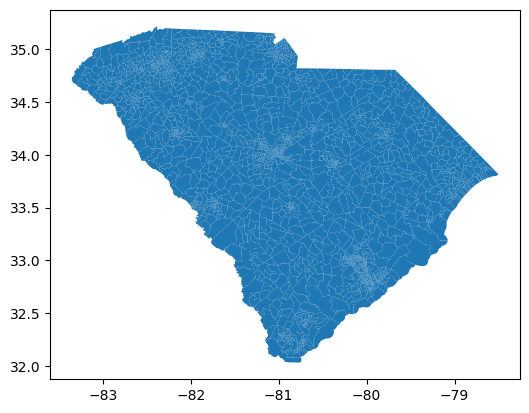

In [47]:
shapefile_path = "./{}/{}.shp".format(state_ab, state_ab)
shape=gpd.read_file(shapefile_path)
shape.plot()